In [59]:
library(dplyr)
library(xtable)
library(survival)

## Plotting
library(ggplot2)
library(cowplot)
library(RColorBrewer)

theme_set(theme_bw())

In [60]:
source("../../R/calc.R")
source("../../R/misc.R")
source("../../R/normalise.R")
source("../../R/plot.R")
source("../../R/predict.R")
source("../../R/subset.R")
source("../../R/utils.R")

## Import data

In [2]:
# Metadata
METADATA_SID <- "../../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [3]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
metadata_pid$label <- as.factor(metadata_pid$label)

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] "No. of probesets removed = 6321"


### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [7]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

## SSM: Predictions

In [8]:
m1_p_alltrain <- read.table("../../tmp/p_d33.tsv", sep = "\t")
m1_p_train <- read.table("../../tmp/p_d33-train.tsv", sep = "\t")
m1_p_test <- read.table("../../tmp/p_d33-test.tsv", sep = "\t")

In [9]:
sid_alltrain <- sort_sid(get_sid(rownames(m1_p_alltrain)))
sid_train <- sort_sid(get_sid(rownames(m1_p_train)))
sid_test <- sort_sid(get_sid(rownames(m1_p_test)))

#### TEL-AML1 (Train & test set)

In [109]:
# idx <- metadata_pid[rownames(m1_p_train), 'subtype'] == 'TEL-AML1'
# telaml1_p_train <- m1_p_train[idx, , drop = FALSE]

In [110]:
# idx <- metadata_pid[rownames(m1_p_test), 'subtype'] == 'TEL-AML1'
# telaml1_p_test <- m1_p_test[idx, , drop = FALSE]

In [10]:
# results <- merge(
#   m1_p_alltrain,
#   yeoh_label[, c("d33_mrd", "d33_mrd_risk", "subtype", "treatment", "label")],
#   by = "row.names"
# )

### Evaluation: Label is affected by other factor

In [ ]:
# Factors that affect prediction label
# Generalise our example

# Recommendation: same no. of categories as actual intervention
# Recommendation has to be made before intervention, otherwise intervention may change risk

## Yeoh (2018): Global ERM
- Feature selection: Top 1000 DE probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)
- Quantile normalisation does not improve results by much

### All train (w/o heterogeneous subtypes)

In [11]:
## Feature selection
X <- yeoh[, sid_alltrain]
n <- ncol(X)
D0 <- X[, 1:(n / 2)]
D8 <- X[, (n / 2 + 1):n]

if (!is_paired(cbind(D0, D8)))
  stop("Patient IDs are not paired..")

wilcox_pvalue <- calc_univariate(wilcox.test, X = D0, Y = D8, paired = TRUE)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(cbind(D0, D8)[ps_wilcox, ])
normal <- t(yeoh[ps_wilcox, sid_normal])
V <- compute_features(response, normal, sid_train, sid_remission)
global_erm_alltrain <- V[, "erm1", drop = F]

Warning message in wilcox.test.default(dots[[1L]][[2L]], dots[[2L]][[2L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[8L]], dots[[2L]][[8L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[137L]], dots[[2L]][[137L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[255L]], dots[[2L]][[255L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[264L]], dots[[2L]][[264L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[302L]], dots[[2L]][[302L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[313L]], dots[[2L]][[313L]], paired = dots[[3L]][[1L]]):
“cannot

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2321L]], dots[[2L]][[2321L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2342L]], dots[[2L]][[2342L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2346L]], dots[[2L]][[2346L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2406L]], dots[[2L]][[2406L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2418L]], dots[[2L]][[2418L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2419L]], dots[[2L]][[2419L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2451L]], dots[[2L]][[2451L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2457L]], dots[[2L]][[2457L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3703L]], dots[[2L]][[3703L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3719L]], dots[[2L]][[3719L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3727L]], dots[[2L]][[3727L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3731L]], dots[[2L]][[3731L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3737L]], dots[[2L]][[3737L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3761L]], dots[[2L]][[3761L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3762L]], dots[[2L]][[3762L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3770L]], dots[[2L]][[3770L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4726L]], dots[[2L]][[4726L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4737L]], dots[[2L]][[4737L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4747L]], dots[[2L]][[4747L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4763L]], dots[[2L]][[4763L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4764L]], dots[[2L]][[4764L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4766L]], dots[[2L]][[4766L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4773L]], dots[[2L]][[4773L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4775L]], dots[[2L]][[4775L]], :


No. of samples in centroid = 36
P005_D8 has a negative comp_LN_D8N!


### Test data (w/o heterogeneous subtypes)

In [12]:
X_train <- yeoh[, sid_train]
n <- ncol(X_train)
D0_train <- X_train[, 1:(n / 2)]
D8_train <- X_train[, (n / 2 + 1):n]

if (!is_paired(cbind(D0_train, D8_train)))
  stop("Patient IDs are not paired..")

# Feature selection (on training set only) without hyperdiploid, others!
wilcox_pvalue <- calc_univariate(wilcox.test, X = D0_train, Y = D8_train, paired = TRUE)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

# Subsetting features
response <- t(yeoh[
  ps_wilcox, sort_sid(union(sid_train, sid_test))
])
normal <- t(yeoh[ps_wilcox, sid_normal])

V <- compute_features(response, normal, sid_train, sid_remission)
global_erm_train <- V[
  unique(substring(sid_train, 1, 4)), # subset train samples
  "erm1", drop = F
]
global_erm_test <- V[
  unique(substring(sid_test, 1, 4)), # subset test samples
  "erm1", drop = F
]

Warning message in wilcox.test.default(dots[[1L]][[2L]], dots[[2L]][[2L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3L]], dots[[2L]][[3L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5L]], dots[[2L]][[5L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[6L]], dots[[2L]][[6L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[8L]], dots[[2L]][[8L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[9L]], dots[[2L]][[9L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[52L]], dots[[2L]][[52L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-v

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[347L]], dots[[2L]][[347L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[352L]], dots[[2L]][[352L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[355L]], dots[[2L]][[355L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[358L]], dots[[2L]][[358L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[361L]], dots[[2L]][[361L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[370L]], dots[[2L]][[370L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[377L]], dots[

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[657L]], dots[[2L]][[657L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[660L]], dots[[2L]][[660L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[666L]], dots[[2L]][[666L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[669L]], dots[[2L]][[669L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[671L]], dots[[2L]][[671L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[672L]], dots[[2L]][[672L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[695L]], dots[

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[873L]], dots[[2L]][[873L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[876L]], dots[[2L]][[876L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[881L]], dots[[2L]][[881L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[883L]], dots[[2L]][[883L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[888L]], dots[[2L]][[888L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[890L]], dots[[2L]][[890L]], paired = dots[[3L]][[1L]]):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[891L]], dots[

“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1017L]], dots[[2L]][[1017L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1021L]], dots[[2L]][[1021L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1023L]], dots[[2L]][[1023L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1025L]], dots[[2L]][[1025L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1026L]], dots[[2L]][[1026L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1030L]], dots[[2L]][[1030L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1036L]], dots[[2L]][[1036L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1038L]], dots[[2L]][[1038L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1234L]], dots[[2L]][[1234L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1235L]], dots[[2L]][[1235L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1236L]], dots[[2L]][[1236L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1237L]], dots[[2L]][[1237L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1238L]], dots[[2L]][[1238L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1239L]], dots[[2L]][[1239L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1240L]], dots[[2L]][[1240L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1245L]], dots[[2L]][[1245L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1379L]], dots[[2L]][[1379L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1390L]], dots[[2L]][[1390L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1391L]], dots[[2L]][[1391L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1394L]], dots[[2L]][[1394L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1395L]], dots[[2L]][[1395L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1396L]], dots[[2L]][[1396L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1399L]], dots[[2L]][[1399L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1400L]], dots[[2L]][[1400L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1515L]], dots[[2L]][[1515L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1517L]], dots[[2L]][[1517L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1519L]], dots[[2L]][[1519L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1520L]], dots[[2L]][[1520L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1523L]], dots[[2L]][[1523L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1524L]], dots[[2L]][[1524L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1526L]], dots[[2L]][[1526L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1527L]], dots[[2L]][[1527L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1642L]], dots[[2L]][[1642L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1643L]], dots[[2L]][[1643L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1644L]], dots[[2L]][[1644L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1645L]], dots[[2L]][[1645L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1646L]], dots[[2L]][[1646L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1649L]], dots[[2L]][[1649L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1651L]], dots[[2L]][[1651L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1656L]], dots[[2L]][[1656L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1748L]], dots[[2L]][[1748L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1750L]], dots[[2L]][[1750L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1751L]], dots[[2L]][[1751L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1752L]], dots[[2L]][[1752L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1753L]], dots[[2L]][[1753L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1754L]], dots[[2L]][[1754L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1755L]], dots[[2L]][[1755L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1757L]], dots[[2L]][[1757L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1836L]], dots[[2L]][[1836L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1838L]], dots[[2L]][[1838L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1839L]], dots[[2L]][[1839L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1840L]], dots[[2L]][[1840L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1842L]], dots[[2L]][[1842L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1843L]], dots[[2L]][[1843L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1844L]], dots[[2L]][[1844L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1845L]], dots[[2L]][[1845L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1918L]], dots[[2L]][[1918L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1919L]], dots[[2L]][[1919L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1920L]], dots[[2L]][[1920L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1921L]], dots[[2L]][[1921L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1923L]], dots[[2L]][[1923L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1924L]], dots[[2L]][[1924L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1926L]], dots[[2L]][[1926L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1927L]], dots[[2L]][[1927L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1996L]], dots[[2L]][[1996L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1997L]], dots[[2L]][[1997L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1998L]], dots[[2L]][[1998L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[1999L]], dots[[2L]][[1999L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2001L]], dots[[2L]][[2001L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2002L]], dots[[2L]][[2002L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2003L]], dots[[2L]][[2003L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2004L]], dots[[2L]][[2004L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2248L]], dots[[2L]][[2248L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2249L]], dots[[2L]][[2249L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2252L]], dots[[2L]][[2252L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2257L]], dots[[2L]][[2257L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2258L]], dots[[2L]][[2258L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2259L]], dots[[2L]][[2259L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2262L]], dots[[2L]][[2262L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2263L]], dots[[2L]][[2263L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2407L]], dots[[2L]][[2407L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2409L]], dots[[2L]][[2409L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2410L]], dots[[2L]][[2410L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2411L]], dots[[2L]][[2411L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2412L]], dots[[2L]][[2412L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2413L]], dots[[2L]][[2413L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2416L]], dots[[2L]][[2416L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2417L]], dots[[2L]][[2417L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2499L]], dots[[2L]][[2499L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2500L]], dots[[2L]][[2500L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2501L]], dots[[2L]][[2501L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2504L]], dots[[2L]][[2504L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2505L]], dots[[2L]][[2505L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2506L]], dots[[2L]][[2506L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2507L]], dots[[2L]][[2507L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2508L]], dots[[2L]][[2508L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2674L]], dots[[2L]][[2674L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2675L]], dots[[2L]][[2675L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2681L]], dots[[2L]][[2681L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2689L]], dots[[2L]][[2689L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2694L]], dots[[2L]][[2694L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2695L]], dots[[2L]][[2695L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2697L]], dots[[2L]][[2697L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2700L]], dots[[2L]][[2700L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2910L]], dots[[2L]][[2910L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2917L]], dots[[2L]][[2917L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2919L]], dots[[2L]][[2919L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2925L]], dots[[2L]][[2925L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2929L]], dots[[2L]][[2929L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2931L]], dots[[2L]][[2931L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2934L]], dots[[2L]][[2934L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[2935L]], dots[[2L]][[2935L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3098L]], dots[[2L]][[3098L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3105L]], dots[[2L]][[3105L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3106L]], dots[[2L]][[3106L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3110L]], dots[[2L]][[3110L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3111L]], dots[[2L]][[3111L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3112L]], dots[[2L]][[3112L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3117L]], dots[[2L]][[3117L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3121L]], dots[[2L]][[3121L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3252L]], dots[[2L]][[3252L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3253L]], dots[[2L]][[3253L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3254L]], dots[[2L]][[3254L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3256L]], dots[[2L]][[3256L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3257L]], dots[[2L]][[3257L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3262L]], dots[[2L]][[3262L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3263L]], dots[[2L]][[3263L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3264L]], dots[[2L]][[3264L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3388L]], dots[[2L]][[3388L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3389L]], dots[[2L]][[3389L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3390L]], dots[[2L]][[3390L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3393L]], dots[[2L]][[3393L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3399L]], dots[[2L]][[3399L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3400L]], dots[[2L]][[3400L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3402L]], dots[[2L]][[3402L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3403L]], dots[[2L]][[3403L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3514L]], dots[[2L]][[3514L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3515L]], dots[[2L]][[3515L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3517L]], dots[[2L]][[3517L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3518L]], dots[[2L]][[3518L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3519L]], dots[[2L]][[3519L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3522L]], dots[[2L]][[3522L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3523L]], dots[[2L]][[3523L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3525L]], dots[[2L]][[3525L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3617L]], dots[[2L]][[3617L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3618L]], dots[[2L]][[3618L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3619L]], dots[[2L]][[3619L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3620L]], dots[[2L]][[3620L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3621L]], dots[[2L]][[3621L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3623L]], dots[[2L]][[3623L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3624L]], dots[[2L]][[3624L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3628L]], dots[[2L]][[3628L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3710L]], dots[[2L]][[3710L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3712L]], dots[[2L]][[3712L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3714L]], dots[[2L]][[3714L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3716L]], dots[[2L]][[3716L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3717L]], dots[[2L]][[3717L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3719L]], dots[[2L]][[3719L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3721L]], dots[[2L]][[3721L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3722L]], dots[[2L]][[3722L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3794L]], dots[[2L]][[3794L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3797L]], dots[[2L]][[3797L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3798L]], dots[[2L]][[3798L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3800L]], dots[[2L]][[3800L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3801L]], dots[[2L]][[3801L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3802L]], dots[[2L]][[3802L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3803L]], dots[[2L]][[3803L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3806L]], dots[[2L]][[3806L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3887L]], dots[[2L]][[3887L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3888L]], dots[[2L]][[3888L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3889L]], dots[[2L]][[3889L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3890L]], dots[[2L]][[3890L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3891L]], dots[[2L]][[3891L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3892L]], dots[[2L]][[3892L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3893L]], dots[[2L]][[3893L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[3896L]], dots[[2L]][[3896L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4145L]], dots[[2L]][[4145L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4146L]], dots[[2L]][[4146L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4148L]], dots[[2L]][[4148L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4154L]], dots[[2L]][[4154L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4156L]], dots[[2L]][[4156L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4160L]], dots[[2L]][[4160L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4161L]], dots[[2L]][[4161L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4164L]], dots[[2L]][[4164L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4359L]], dots[[2L]][[4359L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4360L]], dots[[2L]][[4360L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4361L]], dots[[2L]][[4361L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4364L]], dots[[2L]][[4364L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4365L]], dots[[2L]][[4365L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4369L]], dots[[2L]][[4369L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4371L]], dots[[2L]][[4371L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4373L]], dots[[2L]][[4373L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4490L]], dots[[2L]][[4490L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4494L]], dots[[2L]][[4494L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4495L]], dots[[2L]][[4495L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4497L]], dots[[2L]][[4497L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4499L]], dots[[2L]][[4499L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4500L]], dots[[2L]][[4500L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4503L]], dots[[2L]][[4503L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4504L]], dots[[2L]][[4504L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4628L]], dots[[2L]][[4628L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4633L]], dots[[2L]][[4633L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4634L]], dots[[2L]][[4634L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4635L]], dots[[2L]][[4635L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4636L]], dots[[2L]][[4636L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4637L]], dots[[2L]][[4637L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4639L]], dots[[2L]][[4639L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4640L]], dots[[2L]][[4640L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4739L]], dots[[2L]][[4739L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4740L]], dots[[2L]][[4740L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4742L]], dots[[2L]][[4742L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4743L]], dots[[2L]][[4743L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4745L]], dots[[2L]][[4745L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4747L]], dots[[2L]][[4747L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4748L]], dots[[2L]][[4748L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4751L]], dots[[2L]][[4751L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4824L]], dots[[2L]][[4824L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4826L]], dots[[2L]][[4826L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4827L]], dots[[2L]][[4827L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4828L]], dots[[2L]][[4828L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4829L]], dots[[2L]][[4829L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4830L]], dots[[2L]][[4830L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4831L]], dots[[2L]][[4831L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4833L]], dots[[2L]][[4833L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4899L]], dots[[2L]][[4899L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4900L]], dots[[2L]][[4900L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4901L]], dots[[2L]][[4901L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4902L]], dots[[2L]][[4902L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4903L]], dots[[2L]][[4903L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4904L]], dots[[2L]][[4904L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4905L]], dots[[2L]][[4905L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[4906L]], dots[[2L]][[4906L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5056L]], dots[[2L]][[5056L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5059L]], dots[[2L]][[5059L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5060L]], dots[[2L]][[5060L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5062L]], dots[[2L]][[5062L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5063L]], dots[[2L]][[5063L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5065L]], dots[[2L]][[5065L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5068L]], dots[[2L]][[5068L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5069L]], dots[[2L]][[5069L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5173L]], dots[[2L]][[5173L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5174L]], dots[[2L]][[5174L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5175L]], dots[[2L]][[5175L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5176L]], dots[[2L]][[5176L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5177L]], dots[[2L]][[5177L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5179L]], dots[[2L]][[5179L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5183L]], dots[[2L]][[5183L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5184L]], dots[[2L]][[5184L]], :


“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5311L]], dots[[2L]][[5311L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5313L]], dots[[2L]][[5313L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5315L]], dots[[2L]][[5315L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5318L]], dots[[2L]][[5318L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5321L]], dots[[2L]][[5321L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5323L]], dots[[2L]][[5323L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5324L]], dots[[2L]][[5324L]], :
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(dots[[1L]][[5325L]], dots[[2L]][[5325L]], :


No. of samples in centroid = 36


## Kang et al. (2010)

In [17]:
KANG_RPATH <- "../../data/other_methods/kang_2010-ps.txt"
kang_ps <- readLines(con = KANG_RPATH)

kang_idx <- kang_ps[kang_ps %in% rownames(raw_yeoh)] # 26 probesets
# Select probesets
data_kang <- yeoh_allps[kang_idx, ]

In [18]:
# Subset n = 67 patients
sid_alltrain_d0 <- sid_alltrain[endsWith(sid_alltrain, "_D0")]
d0_kang_alltrain <- data_kang[, sid_alltrain_d0]
colnames(d0_kang_alltrain) <- substring(colnames(d0_kang_alltrain), 1, 4)

# PCA
d0_kang_pca <- prcomp(t(d0_kang_alltrain), center = T, scale. = T)$x
# Survival data
surv_kang <- metadata_pid[
  substring(sid_alltrain_d0, 1, 4),
  c("event_code", "years")
]
kang_alltrain <- cbind(surv_kang, PC1 = d0_kang_pca[, 1])

# Cox PH model
cox_kang <- coxph(
  Surv(years, event_code != 0) ~ PC1,
  data = kang_alltrain
)

# i.e. surv_kang$PC1 * -0.20986
kang_y_alltrain <- predict(cox_kang, newdata = kang_alltrain, type = "lp")

#### Test set

In [19]:
sid_train_d0 <- sid_train[endsWith(sid_train, "_D0")]
kang_train <- data_kang[, sid_train_d0]
colnames(kang_train) <- substring(colnames(kang_train), 1, 4)

sid_test_d0 <- sid_test[endsWith(sid_test, "_D0")]
kang_test <- data_kang[, sid_test_d0]
colnames(kang_test) <- substring(colnames(kang_test), 1, 4)

# PCA
kang_train_pca_obj <- prcomp(t(kang_train), center = T, scale. = T)
kang_train_pca <- kang_train_pca_obj$x
# Survival data
surv_kang <- metadata_pid[
  substring(sid_train_d0, 1, 4),
  c("event_code", "years")
]
surv_pc1_train <- cbind(surv_kang, PC1 = kang_train_pca[, 1])

# Cox PH model
cox_kang <- coxph(
  Surv(years, event_code != 0) ~ PC1,
  data = surv_pc1_train
)
# Train set predictions
kang_y_train <- predict(cox_kang, newdata = surv_pc1_train, type = "lp")

# PCA (project)
kang_test_pca <- predict(kang_train_pca_obj, newdata = t(kang_test))
kang_y_test <- predict(
  cox_kang, newdata = data.frame(kang_test_pca[, 1, drop = F]), type = "lp"
)

## Bhojwani et al. (2009)
- Logistic regression
- LP1 is the model evaluated to be the best by the authors

In [20]:
# BHOJ_RPATH <- "data/other_methods/bhojwani_2008-full.txt"
# bhoj_ps <- readLines(con = BHOJ_RPATH)

# bhoj_ps2 <- c(
#   "200641_s_at",
#   "201472_at",
#   "205401_at",
#   "208820_at",
#   "212576_at"
# )
# bhoj_ps3 <- c(
#   "200641_s_at",
#   "201472_at",
#   "208820_at",
#   "212576_at"
# )

# bhoj_idx0 <- bhoj_ps[bhoj_ps %in% rownames(raw_yeoh)]
# bhoj_idx2 <- bhoj_ps2[bhoj_ps2 %in% rownames(raw_yeoh)]
# bhoj_idx3 <- bhoj_ps3[bhoj_ps3 %in% rownames(raw_yeoh)]

#### All train set

In [21]:
bhoj_ps1 <- c(
  "201472_at",
  "208687_x_at",
  "212576_at"
)
bhoj_idx1 <- bhoj_ps1[bhoj_ps1 %in% rownames(raw_yeoh)] # check if it exists

In [22]:
sid_alltrain_d0 <- sid_alltrain[endsWith(sid_alltrain, "_D0")]
data_bhoj <- yeoh_allps[bhoj_idx1, sid_alltrain_d0]
colnames(data_bhoj) <- substring(colnames(data_bhoj), 1, 4)

bhoj_lab <- as.factor(metadata_pid[substring(sid_alltrain_d0, 1, 4), "label"])
Xy_bhoj <- data.frame(t(data_bhoj), label = bhoj_lab)

bhoj_model <- glm(
  label ~ ., data = Xy_bhoj,
  family = binomial(link = "logit"),
  maxit = 500
)
bhoj_p_alltrain <- predict(bhoj_model, newdata = Xy_bhoj)

In [86]:
# # Predictions using coefficients
# bhoj1 <- d0_alltrain[bhoj_idx1, ]
# beta <- c(-1.5098, -0.9255, 1.0896, -0.3423)
# y_pred <- beta[2:4] %*% data.matrix(bhoj1) + beta[1]
# p <- 1 / (1 + exp(-y_pred))

#### Train/test split

In [23]:
sid_train_d0 <- sid_train[endsWith(sid_train, "_D0")]
bhoj_train <- yeoh_allps[bhoj_idx1, sid_train_d0]
colnames(bhoj_train) <- substring(colnames(bhoj_train), 1, 4)

sid_test_d0 <- sid_test[endsWith(sid_test, "_D0")]
bhoj_test <- yeoh_allps[bhoj_idx1, sid_test_d0]
colnames(bhoj_test) <- substring(colnames(bhoj_test), 1, 4)

bhoj_lab_train <- as.factor(metadata_pid[substring(sid_train_d0, 1, 4), "label"])
bhoj_lab_test <- as.factor(metadata_pid[substring(sid_test_d0, 1, 4), "label"])

Xy_bhoj_train <- data.frame(t(bhoj_train), label = bhoj_lab_train)
Xy_bhoj_test <- data.frame(t(bhoj_test), label = bhoj_lab_test)

bhoj_model <- glm(
  label ~ ., data = Xy_bhoj_train,
  family = binomial(link = "logit"),
  maxit = 500
)
print(summary(bhoj_model))
bhoj_p_train <- predict(bhoj_model, newdata = Xy_bhoj_train)
bhoj_p_test <- predict(bhoj_model, newdata = Xy_bhoj_test)


Call:
glm(formula = label ~ ., family = binomial(link = "logit"), data = Xy_bhoj_train, 
    maxit = 500)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3633  -0.7271  -0.4475   0.0326   2.1537  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)   13.5927    13.9421   0.975   0.3296  
X201472_at    -1.3386     0.8832  -1.516   0.1296  
X208687_x_at   1.1248     0.6749   1.666   0.0956 .
X212576_at    -1.4959     0.7958  -1.880   0.0601 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 53.984  on 47  degrees of freedom
Residual deviance: 44.406  on 44  degrees of freedom
AIC: 52.406

Number of Fisher Scoring iterations: 5



# Plot: ROC

In [24]:
#' @param p dataframe of predictions from model M1
#' @param global_erm
combine_save_roc <- function(
  proba, global_erm, bhoj, kang,
  metadata_pid, show.names = FALSE
) {
  eval_test <- data.frame(
    ssm = proba,
    global_erm = global_erm[rownames(proba), ],
    bhoj = bhoj[rownames(proba)],
    kang = kang[rownames(proba)],
    mrd = metadata_pid[rownames(proba), "d33_mrd"],
    label = metadata_pid[rownames(proba), "label"]
  )
  x_names <- c("SSM", "ERM", "BHOJ", "KANG", "MRD")
  colnames(eval_test) <- c(x_names, "label")
  
  legend_labs <- c(
    "SSM", "Global ERM", "Bhojwani et al. [2008]",
    "Kang et al. [2010]", "Day 33 MRD"
  )
  
  ax_roc <- ggplot_roc(
    eval_test, response = "label", predictor = x_names,
    direction = c(">", ">", "<", "<", "<"),
    pauc.limits = c(1, .8),
    pauc.axis = "specificity",
    plot.names = legend_labs,
    show.names = show.names,
    lwd = .5
  ) 
  
  ax_roc
}

### All train (w/o Hyperdiploid, Others)

In [38]:
roc_alltrain <- combine_save_roc(
  m1_p_alltrain,
  global_erm_alltrain, # Global ERM model built using all subtypes
  bhoj_p_alltrain,
  kang_y_alltrain,
  metadata_pid
)
file <- "~/Dropbox/tmp/m1-roc-alltrain.pdf"
ggsave(file, roc_alltrain, width = 3.5, height = 3.5)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

### Train/test split (w/o Hyperdiploid, Others)

#### Train split

In [39]:
roc_train <- combine_save_roc(
  m1_p_train,
  global_erm_train, # Global ERM model built using all subtypes
  bhoj_p_train,
  kang_y_train,
  metadata_pid
)
file <- "~/Dropbox/tmp/m1-roc-train.pdf"
ggsave(file, roc_train, width = 3.5, height = 3.5)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

#### Test split

In [40]:
roc_test <- combine_save_roc(
  m1_p_test,
  global_erm_test, # Global ERM model built using all subtypes
  bhoj_p_test,
  kang_y_test,
  metadata_pid
)
file <- "~/Dropbox/tmp/m1-roc-test.pdf"
ggsave(file, roc_test, width = 3.5, height = 3.5)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

### TEL-AML1

In [128]:
roc_telaml1_train <- combine_save_roc(
  telaml1_p_train,
  global_erm_train, # Global ERM model built using all subtypes
  bhoj_p_train,
  kang_y_train,
  metadata_pid,
  show.names = TRUE
)
file <- "~/Dropbox/tmp/telaml1-roc-train.pdf"
ggsave(file, roc_telaml1_train, width = 3.5, height = 3.5)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message:
“Ignoring unknown parameters: direction”

In [130]:
roc_telaml1_test <- combine_save_roc(
  telaml1_p_test,
  global_erm_test, # Global ERM model built using all subtypes
  bhoj_p_test,
  kang_y_test,
  metadata_pid,
  show.names = TRUE
)
file <- "~/Dropbox/tmp/telaml1-roc-test.pdf"
ggsave(file, roc_telaml1_test, width = 3.5, height = 3.5)

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Warning message:
“Ignoring unknown parameters: direction”

## Plot: Legend

In [41]:
labels <- c(
  "Bhojwani et al. (2008)",
  "Yeoh et al. (2018)",
  "Kang et al. (2010)",
  "Day 33 MRD",
  "Subtype-specific model"
)
ax <- ggplot(
  economics_long,
  aes(x = date, y = value, col = variable)
) +
  geom_line() +
  scale_color_discrete("", labels = labels) +
  theme(legend.position = "bottom") +
  guides(col = guide_legend(nrow = 2, byrow = TRUE))

ggsave("~/Dropbox/tmp/legend.pdf", ax, width = 8, height = 4)

# Plot: M1 consolidated predictions

### Plot: MRD v.s. Proba

#### All train set

In [42]:
alltrain_features <- cbind(
  m1_p_alltrain,
  metadata_pid[rownames(m1_p_alltrain), c('subtype', 'label', 'd33_mrd')]
)
levels(alltrain_features$label) <- c('Remission', 'Relapse')

In [48]:
# Plot: Scatter
mrd_p_alltrain <- ggplot(
  alltrain_features,
  aes(
    x = p_d33, y = log10(d33_mrd),
    pch = label, fill = subtype,
    stroke = .5
  )
) +
  geom_point(size = 3, color = "black") +
  labs(
    fill = "Subtype",
    pch = "Outcome",
    x = expression(paste('P(Remission|', bold(x["D33"]), ', s)')),
    y = expression(log[10](MRD))
  ) +
  scale_shape_manual(values = c(21, 24)) +
  theme(
    axis.title.x = element_text(size = 14),
    axis.text.x = element_text(size = 12),
    axis.title.y = element_text(size = 14),
    axis.text.y = element_text(size = 12)
  ) +
  guides(fill = guide_legend(override.aes = list(shape=21))) # override bug in ggplot

file <- "~/Dropbox/tmp/mrd_proba-alltrain.pdf"
ggsave(file, mrd_p_alltrain, width = 4.4, height = 3)

### Plot: Proba v.s. Label

In [49]:
# Plot: Jitter - P v.s. Outcome
# Wilcoxon rank sum
list_p <- split(alltrain_features$p_d33, alltrain_features$label)
alltrain_wilcox <- wilcox.test(list_p[[1]], list_p[[2]])
p_label <- sprintf("Wilcoxon rank-sum, p = %.2e", alltrain_wilcox$p.value)

jitter_m1_p_alltrain <- ggplot(
    alltrain_features,
    aes(x = label, y = p_d33)
  ) +
  geom_boxplot(
    aes(group = label),
    outlier.shape = NA
  ) +  
  geom_point(
    aes(fill = subtype),
    position = position_jitterdodge(
      jitter.width = .7,
      dodge.width = .7
    ),
    size = 3, col = "black", pch = 21
  ) +
  annotate(
    geom = "text",
    x = 1.5, y = 1.1,
    label = p_label
  ) +
  labs(
    fill = "Subtype",
    y = expression(paste('P(Remission|', bold(x["D33"]), ', s)'))
  ) +
  theme(
    axis.title.x = element_blank(),
    axis.text.x = element_text(size = 12),
    axis.title.y = element_text(size = 14),
    axis.text.y = element_text(size = 12),
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 10)
  )

In [51]:
WPATH <- "~/Dropbox/tmp/jitter-alltrain.pdf"
ggsave(WPATH, jitter_m1_p_alltrain, width = 4.8, height = 3)

# Survival analysis

### All train set

In [52]:
# Discretise p(remission|x)
ssm_risk <- character(nrow(m1_p_alltrain))
ssm_risk[m1_p_alltrain > 0.5] <- "SR"
ssm_risk[m1_p_alltrain <= 0.5] <- "IR"
ssm_risk[m1_p_alltrain <= 0.25] <- "HR"
ssm_risk <- as.factor(ssm_risk)
ssm_risk <- factor(ssm_risk, levels = rev(levels(ssm_risk))) # Reverse levels
names(ssm_risk) <- rownames(m1_p_alltrain)

In [53]:
surv_alltrain <- cbind(ssm_risk,
  metadata_pid[names(ssm_risk), c('d33_mrd_risk', 'years', 'event_code')]
)
surv_alltrain$d33_mrd_risk <- droplevels(surv_alltrain$d33_mrd_risk)
# In order for colors to match risk levels
surv_alltrain$ssm_risk <- factor(
  surv_alltrain$ssm_risk,
  c('HR', 'IR', 'SR')
)

#### Kaplan-Meier model: SSM

In [54]:
km_alltrain_ssm <- survfit(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_alltrain
)

# Log-rank test
alltrain_logrank <- survdiff(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_alltrain
)
# p-value
alltrain_pval <- pchisq(
  alltrain_logrank$chisq,
  length(alltrain_logrank$n) - 1,
  lower.tail = F
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/tmp/m1-km_alltrain-ssm.pdf"
pdf(WPATH, width = 4.5, height = 5)

COL <- ggplot_palette(3)
plot(
  km_alltrain_ssm, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  x = 4, y = .55, col = COL,
  legend = c(
    "SSM High Risk",
    "SSM Intermediate Risk",
    "SSM Standard Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)
text(
  x = 7, y = .85,
  sprintf("Log-rank, p = %.2e", alltrain_pval)
)

dev.off()

png 
  2

In [55]:
# 5 year EFS
summary(km_alltrain_ssm, times = 5)
# Log-rank test
alltrain_logrank <- survdiff(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_alltrain
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ ssm_risk, data = surv_alltrain)

                ssm_risk=HR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        3.000       11.000        0.267        0.114        0.115 
upper 95% CI 
       0.617 

                ssm_risk=IR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000       11.000        6.000        0.696        0.104        0.520 
upper 95% CI 
       0.932 

                ssm_risk=SR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
           5           19            0            1            0            1 
upper 95% CI 
           1 


#### Kaplan-Meier model: MRD

In [56]:
km_alltrain_mrd <- survfit(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain
)

# Log-rank test
alltrain_mrd_logrank <- survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain
)
# p-value
alltrain_mrd_pval <- pchisq(
  alltrain_mrd_logrank$chisq,
  length(alltrain_mrd_logrank$n) - 1,
  lower.tail = F
)

# Plot: Kaplan-Meier
WPATH <- "~/Dropbox/tmp/m1-km_alltrain-mrd.pdf"
pdf(WPATH, width = 4.5, height = 5)

COL <- ggplot_palette(3)
plot(
  km_alltrain_mrd, col= COL, las = 1, lwd = 2, mark.time = T,
  xlab = "Years", ylab = "Event-free survival probability"
)
legend(
  "bottomright", col = COL,
  legend=c(
    "MRD High Risk",
    "MRD Intermediate Risk",
    "MRD Standard Risk"
  ),
  bg = "white", lwd = 2, lty = 1, cex = 0.8
)
text(
  x = 7.5, y = .5,
  sprintf("Log-rank, p = %.2e", alltrain_mrd_pval)
)

dev.off()

png 
  2

In [57]:
# 5 year EFS
summary(km_alltrain_mrd, times = 5)
# Log-rank test
survdiff(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  data = surv_alltrain
)
# Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_alltrain)

                d33_mrd_risk=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        3.000        8.000        0.333        0.136        0.150 
upper 95% CI 
       0.742 

                d33_mrd_risk=Intermediate 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       5.000        7.000        5.000        0.680        0.122        0.479 
upper 95% CI 
       0.965 

                d33_mrd_risk=Standard 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      5.0000      23.0000       4.0000       0.8917       0.0512       0.7969 
upper 95% CI 
      0.9979 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_alltrain)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
d33_mrd_risk=High         12        8     2.14   16.0115    18.798
d33_mrd_risk=Intermediate 17        5     4.43    0.0738     0.101
d33_mrd_risk=Standard     38        4    10.43    3.9633    10.417

 Chisq= 20.6  on 2 degrees of freedom, p= 3e-05 

### TODO
#### Kaplan-Meier model: Treatment arm

### Test set

In [45]:
# ssm_p_test <- m1_p_test

# # Subset test set
# surv_test <- yeoh_label1[unique(substring(sid_test, 1, 4)), ]
# # Discretise p(remission|x)
# p_test_cat <- character(nrow(ssm_p_test))
# p_test_cat[ssm_p_test > 0.5] <- "SR"
# p_test_cat[ssm_p_test <= 0.5] <- "IR"
# p_test_cat[ssm_p_test <= 0.25] <- "HR"
# p_test_cat <- as.factor(p_test_cat)
# names(p_test_cat) <- rownames(ssm_p_test)
# # Reverse levels
# p_test_cat1 <- factor(p_test_cat, levels = rev(levels(p_test_cat)))
# print(p_test_cat1)
# # Join table and vector with different pid ordering
# surv_test1 <- merge(surv_test, p_test_cat1, by = "row.names")

P175 P102 P145 P161 P131 P137 P211 P103 P151 P099 P106 P120 P121 P127 P135 P136 
  SR   HR   IR   SR   HR   IR   SR   IR   SR   SR   SR   SR   IR   SR   SR   IR 
P147 P156 P166 
  SR   SR   SR 
Levels: SR IR HR


#### Kaplan-Meier model: SSM

In [169]:
# # EFS - 0 v.s. 1 & 2
# km_test_ssm <- survfit(
#   Surv(years, event_code != 0) ~ y,
#   data = surv_test1
# )

# # Plot: Kaplan-Meier
# WPATH <- "~/Dropbox/temp/km_test-ssm.pdf"
# pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_test_ssm, col= COL, las = 1, lwd = 2, mark.time = T,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate Risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# dev.off()

png 
  2

In [886]:
# # 5 year EFS
# summary(km_test_ssm, times = 3)
# # Log-rank test
# survdiff(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_test1
# )
# # Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ p_cat3, data = surv_test)

                p_cat3=SR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       7.0000       1.0000       0.9091       0.0867       0.7541 
upper 95% CI 
      1.0000 

                p_cat3=IR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
           3            3            0            1            0            1 
upper 95% CI 
           1 

                p_cat3=HR 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       1.0000       4.0000       0.2000       0.1789       0.0346 
upper 95% CI 
      1.0000 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ p_cat3, data = surv_test)

           N Observed Expected (O-E)^2/E (O-E)^2/V
p_cat3=SR 11        1    2.995     1.329      3.33
p_cat3=IR  3        0    0.926     0.926      1.14
p_cat3=HR  5        4    1.078     7.917     10.20

 Chisq= 10.3  on 2 degrees of freedom, p= 0.006 

#### Kaplan-Meier model: MRD

In [170]:
# # EFS - 0 v.s. 1 & 2
# km_test_mrd <- survfit(
#   Surv(years, event_code != 0) ~ d33_mrd_risk,
#   data = surv_test1
# )

# # Plot: Kaplan-Meier
# WPATH <- "~/Dropbox/temp/km_test-mrd.pdf"
# pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_test_mrd, col= COL, las = 1, lwd = 2, mark.time = T,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend=c(
#     "MRD Standard Risk",
#     "MRD Intermediate risk",
#     "MRD High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# dev.off()

png 
  2

In [103]:
# # 5 year EFS
# summary(km_test_mrd, times = 3)
# # Log-rank test
# survdiff(
#   Surv(years, event_code != 0) ~ d33_mrd_risk,
#   data = surv_test1
# )
# # Plot: CIF (Event: relapse) - Gray's test

Call: survfit(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_test1)

                d33_mrd_risk=Standard 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       9.0000       1.0000       0.9167       0.0798       0.7729 
upper 95% CI 
      1.0000 

                d33_mrd_risk=Intermediate 
        time       n.risk      n.event     survival      std.err lower 95% CI 
       3.000        1.000        1.000        0.667        0.272        0.300 
upper 95% CI 
       1.000 

                d33_mrd_risk=High 
        time       n.risk      n.event     survival      std.err lower 95% CI 
      3.0000       1.0000       3.0000       0.2500       0.2165       0.0458 
upper 95% CI 
      1.0000 


Call:
survdiff(formula = Surv(years, event_code != 0) ~ d33_mrd_risk, 
    data = surv_test1)

                           N Observed Expected (O-E)^2/E (O-E)^2/V
d33_mrd_risk=Standard     12        1    3.304   1.60684   4.75922
d33_mrd_risk=Intermediate  3        1    0.926   0.00586   0.00721
d33_mrd_risk=High          4        3    0.769   6.46605   7.78223

 Chisq= 8.2  on 2 degrees of freedom, p= 0.02 

#### Kaplan-Meier: Stratify by MRD

In [91]:
# # Stratify into separate MRD categories and plot KM
# idx_hr <- surv_test1$d33_mrd_risk != "Standard"
# surv_hr <- surv_test1[idx_hr, ]
# surv_sr <- surv_test1[!idx_hr, ]

# km_hr <- survfit(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_hr 
# )
# # # Plot: Kaplan-Meier
# # WPATH <- "~/Dropbox/temp/km-mrd_test.pdf"
# # pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_hr, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# # dev.off()

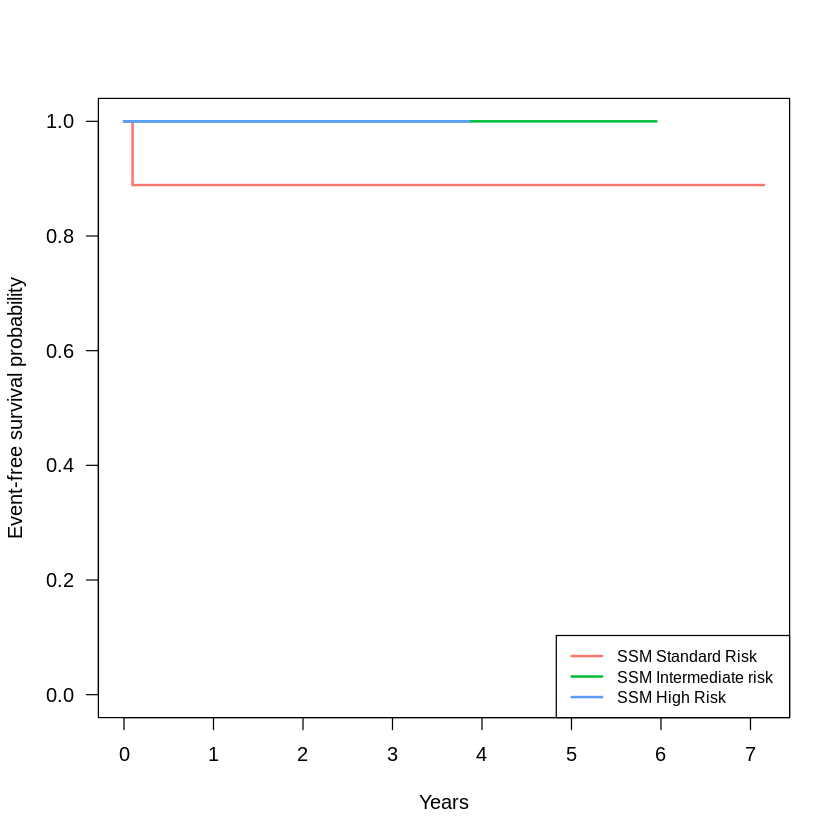

In [90]:
# km_sr <- survfit(
#   Surv(years, event_code != 0) ~ ssm_risk,
#   data = surv_sr
# )
# # # Plot: Kaplan-Meier
# # WPATH <- "~/Dropbox/temp/km-mrd_test.pdf"
# # pdf(WPATH, width = 5, height = 5.5)

# COL <- ggplot_palette(3)
# plot(
#   km_sr, col= COL, las = 1, lwd = 2,
#   xlab = "Years", ylab = "Event-free survival probability"
# )
# legend(
#   "bottomright", col = COL,
#   legend = c(
#     "SSM Standard Risk",
#     "SSM Intermediate risk",
#     "SSM High Risk"
#   ),
#   bg = "white", lwd = 2, lty = 1, cex = 0.8
# )

# # dev.off()

## Cox PH model
- Coefficients and HRs are extremely large
- Due to standard risk having no events at all

In [93]:
# multi_cox <- coxph(
#   Surv(years, event_code != 0) ~ p_cat1,
#   data = surv_alltrain
# )
# summary(multi_cox)

In [92]:
# multi_cox <- coxph(
#   Surv(years, event_code != 0) ~ d33_mrd_risk,
#   data = surv_alltrain
# )
# summary(multi_cox)

In [701]:
# # Check: Linearity assumption
# plot(predict(multi_cox), residuals(multi_cox, type = "martingale"))
# lines(smooth.spline(predict(multi_cox),
#                     residuals(multi_cox, type = "deviance")))

# # Check: Proportional hazards assumption
# plot(cox.zph(multi_cox)[1])

In [688]:
# Multivariate Fine and Gray
# Adjust for subtype, NCI risk criteria
# bmtcrrMat <- model.matrix(object = ~ D + Age + Sex + Phase + Source, data = bmtcrr)

# bmtcrrMat <- bmtcrrMat[,-1]
# head(bmtcrrMat)
# resCrrRel <- crr(ftime    = bmtcrr$ftime, # vector of failure/censoring times
#                  fstatus  = bmtcrr$Status, # vector with a unique code for each failure type and censoring
#                  cov1     = bmtcrrMat, #  matrix (nobs x ncovs) of fixed covariates
#                  ## cov2     = , # matrix of covariates that will be multiplied by functions of time
#                  ## tf       = , # functions of time
#                  ## cengroup = , # vector with different values for each group with a distinct censoring distribution
#                  failcode = "Relapse", # code of fstatus that denotes the failure type of interest
#                  cencode  = "Censored" # code of fstatus that denotes censored observations
#                  )
# summary(resCrrRel)

## Table of pAUC values (FPR = 0, 0.2)

In [126]:
# Metadata of table pAUC values
# Remission samples lie on the FPR
roc_metadata <- t(sapply(
  list_X_y,
  function(X) table(yeoh_label[rownames(X), "label"])
))
rownames(roc_metadata) <- subtypes
print(roc_metadata)

              0  1
BCR-ABL       5  5
E2A-PBX1      5  1
Hyperdiploid 31  4
MLL           3  4
Others       63 20
T-ALL         8  2
TEL-AML1     29  5


In [100]:
feats <- c(
  "angle_d0d8_d0normal", "erm1_ratio2", "l2norm_ratio2",
  "log_mrd", "p_rem", "global_erm"
)

list_rocs <- lapply(
  list_X_y,
  plot_roc,
  response = "label",
  predictor = feats,
  pauc.limits = c(1, 0.8),
  pauc.axis = "specificity",
  return.auc = T,
)

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls > cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in auc.roc(roc, ...):
“Partial AUC correction not defined for ROC curves below the diagonal.”Setting levels: control = 0, case = 1
Sett

In [101]:
list_rocplots <- lapply(list_rocs, function(obj) obj$plot)
list_aucs <- lapply(list_rocs, function(obj) obj$auc)

In [453]:
# for (i in seq_along(list_rocplots)) {
#   wpath <- sprintf("~/Dropbox/temp/roc-%s.pdf", subtypes[i])
#   print(wpath)
#   ggsave(wpath, list_rocplots[[i]], width = 6, height = 6)
# }

[1] "~/Dropbox/temp/roc-BCR-ABL.pdf"
[1] "~/Dropbox/temp/roc-E2A-PBX1.pdf"
[1] "~/Dropbox/temp/roc-Hyperdiploid.pdf"
[1] "~/Dropbox/temp/roc-MLL.pdf"
[1] "~/Dropbox/temp/roc-Others.pdf"
[1] "~/Dropbox/temp/roc-T-ALL.pdf"
[1] "~/Dropbox/temp/roc-TEL-AML1.pdf"


In [107]:
names(list_aucs) <- subtypes
auc_tab <- do.call(rbind, list_aucs)
print(auc_tab[, c(5,4,6)])
print(xtable(auc_tab[, c(5,4,6)], digits = 3))

                 p_rem   log_mrd global_erm
BCR-ABL      0.7777778 0.8888889         NA
E2A-PBX1     1.0000000        NA  1.0000000
Hyperdiploid 0.6330645 0.7222222  0.6102151
MLL          1.0000000 0.7222222  0.5833333
Others       0.5017637 0.6710317  0.5194004
T-ALL        0.7395833        NA         NA
TEL-AML1     0.7394636 0.5905492  0.6628352
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Mar 12 15:18:47 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
  \hline
 & p\_rem & log\_mrd & global\_erm \\ 
  \hline
BCR-ABL & 0.778 & 0.889 &  \\ 
  E2A-PBX1 & 1.000 &  & 1.000 \\ 
  Hyperdiploid & 0.633 & 0.722 & 0.610 \\ 
  MLL & 1.000 & 0.722 & 0.583 \\ 
  Others & 0.502 & 0.671 & 0.519 \\ 
  T-ALL & 0.740 &  &  \\ 
  TEL-AML1 & 0.739 & 0.591 & 0.663 \\ 
   \hline
\end{tabular}
\end{table}


### Test data (w Hyper, Others)

In [454]:
# Concatenate global ERM to X_y
# OPTION: list_obj1 created with variant function predict_plot
list_X_y <- lapply(
  list_obj,
  function(obj, global_erm) {
    cbind(obj$X_y,
          global_erm = global_erm[rownames(obj$X_y), ])
  },
  global_erm_test1
)

In [519]:
list_boxplots <- lapply(list_X_y, plot_boxplot)
for (i in seq_len(length(subtypes))) {
  wpath <- sprintf("~/Dropbox/temp/features_test-%s.pdf",
                   subtypes[i])
  ggsave(wpath, list_boxplots[[i]],
         width = 10, height = 3)
}

                feature    value       lab
log_mrd    log[10](MRD) -4.00000 p = 0.097
global_erm 'Global ERM' 56.07634 p = 0.815
                                       feature    value       lab
log_mrd                           log[10](MRD) -5.00000 p = 0.161
global_erm                        'Global ERM' 87.29912 p = 0.176
p_rem      paste('P(Remission|', bold(x), ')')  0.92500 p = 0.369
                                       feature      value       lab
log_mrd                           log[10](MRD) -5.0000000 p = 0.004
global_erm                        'Global ERM' 98.3373024 p = 0.271
p_rem      paste('P(Remission|', bold(x), ')')  0.8076923 p = 0.679


In [686]:
subtype <- subtypes[[1]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[
  , Y[colnames(raw_delta_D0N), "subtype"] == subtype
]
raw_delta_D0D8_1 <- raw_delta_D0D8[
  , Y[colnames(raw_delta_D0D8), "subtype"] == subtype
]

stopifnot(substring(colnames(raw_delta_D0N_1),1,4) ==
          substring(colnames(raw_delta_D0D8_1),1,4))

mu_delta <- apply(raw_delta_D0N_1, 1, mean)
var_delta <- apply(raw_delta_D0N_1, 1, var)
# plot(mu_delta, var_delta)
THRESHOLD <- 3
idx_subnetwork <- names(mu_delta)[mu_delta > THRESHOLD]
print(length(idx_subnetwork))

## Selecting subnetworks with significant dysregulation
raw_delta_D0D8_2 <- raw_delta_D0D8_1[idx_subnetwork, ]
raw_delta_D0N_2 <- raw_delta_D0N_1[idx_subnetwork, ]

# print(colnames(delta_D0D8_1)[
#   Y[colnames(delta_D0D8_1), "label"] == 1
# ])

pct_delta <- raw_delta_D0D8_2 / raw_delta_D0N_2
pct_delta1 <- colMeans(raw_delta_D0D8_2) / colMeans(raw_delta_D0N_2)

[1] "BCR-ABL"
[1] 90


In [386]:
subtype <- subtypes[[2]]
print(subtype)
raw_delta_D0N_1 <- raw_delta_D0N[, Y[colnames(raw_delta_D0N), "subtype"] == subtype]
raw_delta_D0D8_1 <- raw_delta_D0D8[, Y[colnames(raw_delta_D0D8), "subtype"] == subtype]

stopifnot(substring(colnames(delta_D0N_1),1,4) ==
          substring(colnames(delta_D0D8_1),1,4))

# pct_delta <- delta_D0D8_1 / delta_D0N_1
# print(Y[colnames(pct_delta), "label"])
# plot(pct_delta, col = Y[names(pct_delta), "label"] + 1)

[1] "E2A-PBX1"


## Contingency table

### Data set: All train

#### SSM w/ MRD

In [84]:
### Subset alltrain set
surv_alltrain <- yeoh_label1[unique(substring(sid_alltrain, 1, 4)), ]

## SSM w/ MRD
ssm_p_alltrain <- m1_p_alltrain
# Discretise p(remission|x)
ssm_risk <- character(nrow(ssm_p_alltrain))
ssm_risk[ssm_p_alltrain > 0.5] <- "SR"
ssm_risk[ssm_p_alltrain <= 0.5] <- "IR"
ssm_risk[ssm_p_alltrain <= 0.25] <- "HR"
ssm_risk <- as.factor(ssm_risk)
ssm_risk <- factor(ssm_risk, levels = rev(levels(ssm_risk))) # Reverse levels
names(ssm_risk) <- rownames(ssm_p_alltrain)

## SSM w/o MRD
ssm_p1_alltrain <- m1a_p_alltrain
# Discretise p(remission|x)
ssm_risk1 <- character(nrow(ssm_p1_alltrain))
ssm_risk1[ssm_p1_alltrain > 0.5] <- "SR"
ssm_risk1[ssm_p1_alltrain <= 0.5] <- "IR"
ssm_risk1[ssm_p1_alltrain <= 0.25] <- "HR"
ssm_risk1 <- as.factor(ssm_risk1)
ssm_risk1 <- factor(ssm_risk1, levels = rev(levels(ssm_risk1))) # Reverse levels
names(ssm_risk1) <- rownames(ssm_p1_alltrain)

# Join table and vector with different pid ordering
surv_alltrain1 <- cbind(
  surv_alltrain,
  ssm_risk = ssm_risk[rownames(surv_alltrain)]
)
surv_alltrain2 <- cbind(
  surv_alltrain1,
  ssm_womrd_risk = ssm_risk1[rownames(surv_alltrain1)]
)
head(surv_alltrain2)

,d33_mrd,d33_mrd_risk,Status,event_code,label,years,training_test,subtype,ssm_risk,ssm_womrd_risk
,<dbl>,<fct>,<fct>,<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>
P001,5e-04,Intermediate,CCR,0,0,3.264,Training set,T-ALL,SR,SR
P004,8e-02,High,CCR,0,0,9.766,Training set,T-ALL,SR,SR
P005,1e-04,Standard,CCR,0,0,9.506,Training set,T-ALL,SR,SR
P007,4e-03,Intermediate,Relapse (Induction),1,1,0.003,Training set,T-ALL,IR,HR
P008,1e-04,Standard,CCR,0,0,8.446,Training set,T-ALL,SR,SR
P010,1e-04,Standard,CCR,0,0,10.525,Training set,T-ALL,HR,HR


In [98]:
# Replace SSM w/o MRD: IR with SSM w/ MRD predictions
# SSM Strategy
ssm_strategy <- surv_alltrain2$ssm_womrd_risk
idx_ihrisk <- ssm_strategy %in% c("IR", "HR")
ssm_strategy[idx_ihrisk] <- surv_alltrain2$ssm_risk[idx_ihrisk]
surv_alltrain2$ssm_strategy <- ssm_strategy

In [100]:
table(surv_alltrain2$ssm_strategy, surv_alltrain2$label)

    
      0  1
  SR 31  0
  IR 18  8
  HR  1  9

#### Accuracy, Sensitivity, Specificity (with negative scoring)

In [101]:
#' @y_pred factor vector of prediction labels in {"SR", "IR", "HR"}
#' @param y_true truth labels represented by 0, 1
# +1 for correct predictions, -1 for wrong predictions
# Assumption: No intermediate risk
calc_neg_accuracy <- function(y_true, y_pred, verbose = F) {
  y_pred_sub <- y_pred[y_pred != "IR"]
  y_true_sub <- y_true[y_pred != "IR"]
  y_pred_sub <- ifelse(y_pred_sub == "HR", 1, 0)
  if (verbose)
    print(cbind(y_pred_sub, y_true_sub))
  
  sum(ifelse(y_true_sub == y_pred_sub, 1, -1)) / length(y_true)
}
#' @y_pred factor vector of prediction labels in {"SR", "IR", "HR"}
#' @param y_true truth labels represented by 0, 1
# +1 for correct predictions, -1 for wrong predictions
# Assumption: No intermediate risk
calc_neg_sensitivity <- function(y_true, y_pred, verbose = F) {
  ap <- y_true[y_true == 1]
  y_pred_sub <- y_pred[y_true == 1]
  y_pred_sub1 <- y_pred_sub[y_pred_sub != "IR"]
  ap_sub <- ap[y_pred_sub != "IR"]
  y_pred_sub1 <- ifelse(y_pred_sub1 == "HR", 1, 0)
  if (verbose)
    print(cbind(ap_sub, y_pred_sub1))
  sum(ifelse(ap_sub == y_pred_sub1, 1, -1)) / length(ap)
}
#' @y_pred factor vector of prediction labels in {"SR", "IR", "HR"}
#' @param y_true truth labels represented by 0, 1
# +1 for correct predictions, -1 for wrong predictions
# Assumption: No intermediate risk
calc_neg_specificity <- function(y_true, y_pred, verbose = F) {
  an <- y_true[y_true == 0]
  y_pred_sub <- y_pred[y_true == 0]
  y_pred_sub1 <- y_pred_sub[y_pred_sub != "IR"]
  an_sub <- an[y_pred_sub != "IR"]
  y_pred_sub1 <- ifelse(y_pred_sub1 == "HR", 1, 0)
  if (verbose)
    print(cbind(an_sub, y_pred_sub1))
  sum(ifelse(an_sub == y_pred_sub1, 1, -1)) / length(an)
}

In [104]:
calc_neg_accuracy(surv_alltrain2$label, surv_alltrain2$ssm_risk)
calc_neg_sensitivity(surv_alltrain2$label, surv_alltrain2$ssm_risk)
calc_neg_specificity(surv_alltrain2$label, surv_alltrain2$ssm_risk)

[1] 0.5820896

[1] 0.5294118

[1] 0.6

In [30]:
mrd_risk <- factor(
  surv_alltrain1$d33_mrd_risk,
  labels = c("SR", "IR", "HR")
)
calc_neg_accuracy(surv_alltrain1$label, mrd_risk)
calc_neg_sensitivity(surv_alltrain1$label, mrd_risk)
calc_neg_specificity(surv_alltrain1$label, mrd_risk)

[1] 0.5074627

[1] 0.2352941

[1] 0.6

## Finding classification threshold

In [436]:
# Calculate threshold that maximises recall and specificity
# for global ERM predictions
#' @param X_train dataframe of global ERM features of training set
#' @param X_test dataframe of global ERM features of test set
#' @param metadata dataframe of metadata with pid as rownames (yeoh_label)
argmax_threshold <- function(X_train, metadata) {
  X_train_y <- data.frame(
    X_train,
    label = metadata[rownames(X_train), "label"]
  )

  roc_obj <- pROC::roc(X_train_y, "label", "erm1", direction = ">")
  # NOTE: roc function calculates thresholds by taking the 
  # arithmetic mean of two adjacent points
  roc_thresholds <- data.frame(
    roc_obj$thresholds,
    roc_obj$sensitivities,
    roc_obj$specificities
  )
  roc_thresholds$mean <- mapply(
    function(x, y) mean(c(x, y)),
    roc_obj$sensitivities,
    roc_obj$specificities
  )

  threshold <- roc_thresholds[
    which.max(roc_thresholds$mean), "roc_obj.thresholds"
  ]
  
  threshold
}

#' @return dataframe of original test set features concatenated with
#' predictions based on threshold
predict_test <- function(X_test, threshold, metadata) {
  data.frame(
    X_test,
    label = metadata[rownames(X_test), "label"],
    y_pred = ifelse(X_test$erm1 < threshold, 1, 0)
  )  
}

threshold <- argmax_threshold(global_erm_train1, yeoh_label)
global_erm_test1_all <- predict_test(global_erm_test1, threshold, yeoh_label)
recall <- calc_recall(global_erm_test1_all$label, global_erm_test1_all$y_pred)
specificity <- calc_specificity(global_erm_test1_all$label, global_erm_test1_all$y_pred)

Setting levels: control = 0, case = 1


[1] 53.4722
[1] 0.875
[1] 0.4683544


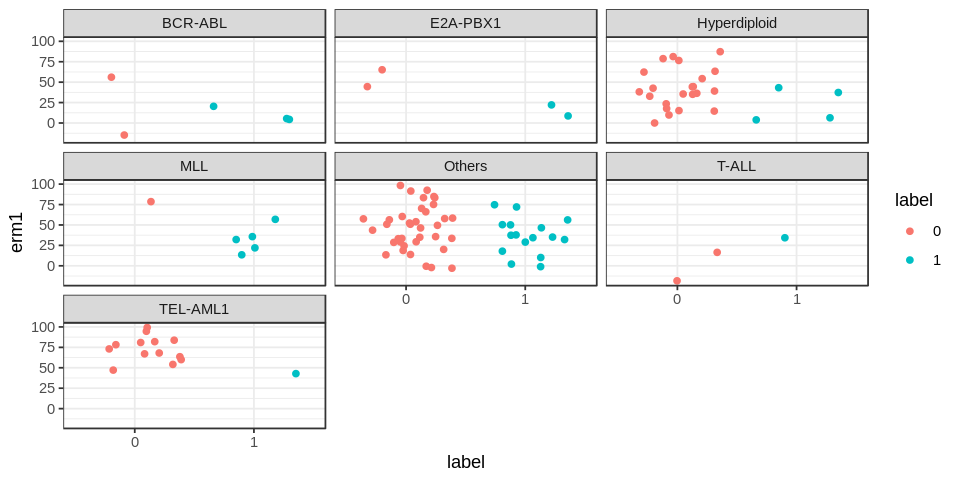

In [441]:
print(threshold)
print(recall)
print(specificity)
global_erm_test1_all2 <- global_erm_test1_all
global_erm_test1_all2$label <- as.factor(global_erm_test1_all2$label)
global_erm_test1_all2$subtype <- yeoh_label[
  rownames(global_erm_test1_all2), "subtype"
]

ggplot(global_erm_test1_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

In [378]:
# Calculate threshold that maximises recall and specificity
# class(yeoh_label[rownames(global_erm_train2), "label"])
global_erm_train2_y <- data.frame(
  global_erm_train2,
  label = yeoh_label[rownames(global_erm_train2), "label"]
)

roc_obj <- pROC::roc(
  global_erm_train2_y,
  "label",
  "erm1",
  direction = ">"
)
# NOTE: roc function calculates thresholds by taking the 
# arithmetic mean of two adjacent points
roc_thresholds <- data.frame(
  roc_obj$thresholds,
  roc_obj$sensitivities,
  roc_obj$specificities
)
roc_thresholds$mean <- mapply(
  function(x, y) mean(c(x, y)),
  roc_obj$sensitivities,
  roc_obj$specificities
)

Setting levels: control = 0, case = 1


In [395]:
threshold <- roc_thresholds[which.max(roc_thresholds$mean), "roc_obj.thresholds"]

global_erm_test2_all <- data.frame(
  global_erm_test2,
  label = yeoh_label[rownames(global_erm_test2), "label"],
  y_pred = ifelse(global_erm_test2$erm1 < threshold, 1, 0)
)

global_erm_test2_recall <- calc_recall(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
global_erm_test2_specificity <- calc_specificity(
  global_erm_test2_all$label,
  global_erm_test2_all$y_pred
)
print(global_erm_test2_recall)
print(global_erm_test2_specificity)

[1] 0.9166667
[1] 0.8


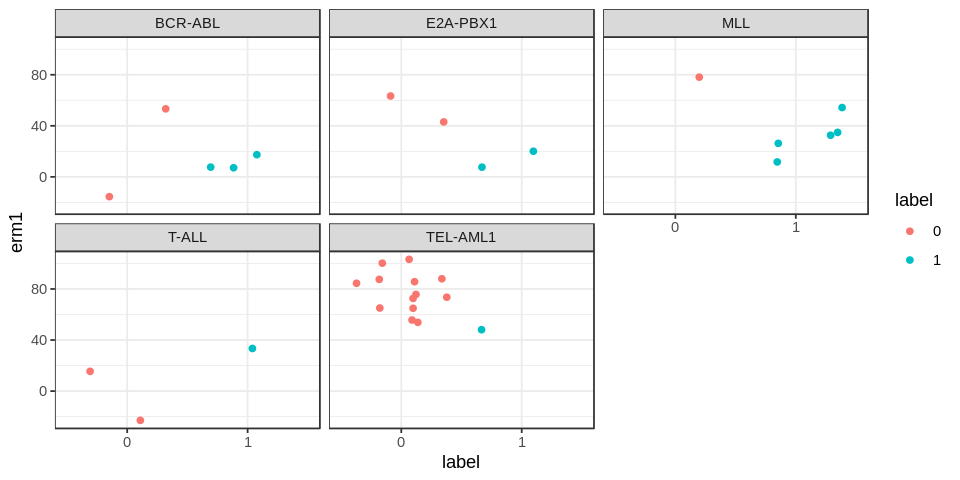

In [443]:
global_erm_test2_all2 <- global_erm_test2_all
global_erm_test2_all2$label <- as.factor(global_erm_test2_all2$label)
global_erm_test2_all2$subtype <- yeoh_label[
  rownames(global_erm_test2_all2), "subtype"
]

ggplot(global_erm_test2_all2,
       aes(label, erm1, colour = label)) +
  geom_point(position = position_jitter()) +
  facet_wrap(~subtype)

## Evaluation: Treatment type

In [311]:
RPATH <- "data/evaluation/evaluation_table.tsv"
scoring_table <- read.table(RPATH, header = T, sep = "\t")
rownames(scoring_table) <- paste0(
  scoring_table$treatment,
  scoring_table$label,
  scoring_table$prediction
)

In [312]:
p_alltrain <- read.table("tmp/m1-p_alltrain.tsv", sep = "\t")

In [355]:
#' Discretise P(remission|x)
#' @param p dataframe with one column containing probability values
#' @param x1 numeric indicating SR threshold
#' @param x2 numeric indicating HR threshold
discretise_proba <- function(p, x1 = .5, x2 = .25) {
  risk <- character(nrow(p))
  risk[p > x1] <- "SR"
  risk[p <= x1] <- "IR"
  risk[p <= x2] <- "HR"
  names(risk) <- rownames(p)
  
  risk[order(names(risk))]
}

In [451]:
ssm_risk1 <- discretise_proba(p_alltrain, .4, .15)
ssm_risk2 <- discretise_proba(p_alltrain, .45, .2)
ssm_risk3 <- discretise_proba(p_alltrain)
ssm_risk4 <- discretise_proba(p_alltrain, .55, .3)
ssm_risk5 <- discretise_proba(p_alltrain, .6, .35)

In [452]:
risk_prediction <- data.frame(
  treatment = yeoh_label[names(ssm_risk1), "treatment_type"],
  label = yeoh_label[names(ssm_risk1), "label"],
  ssm_risk1,
  ssm_risk2,
  ssm_risk3,
  ssm_risk4,
  ssm_risk5
)
risk_prediction$treatment[risk_prediction$treatment == "BMT"] <- "HR"

In [453]:
list_frequency <- list()
list_risk <- list(
  ssm_risk1, ssm_risk2,
  ssm_risk3, ssm_risk4, ssm_risk5
)
for (col in list_risk) {
  eval_distribution <- risk_prediction %>%
    group_by(treatment, label, eval(quote(col))) %>%
    summarise(n = n()) %>%
    as.data.frame()
  colnames(eval_distribution)[3] <- "prediction"
  
  # Add in empty rows  
  rownames(eval_distribution) <- paste0(
    eval_distribution$treatment,
    eval_distribution$label,
    eval_distribution$prediction
  )
  eval_distribution1 <- cbind(
    scoring_table,
    frequency = eval_distribution[rownames(scoring_table), "n"]
  )
  eval_distribution1$frequency[
    is.na(eval_distribution1$frequency)] <- 0
  list_frequency <- append(
    list_frequency,
    eval_distribution1[, "frequency", drop = F]
  )
}

In [467]:
frequencies <- do.call(cbind, list_frequency)
total_scores <- colSums(scoring_table$score * frequencies)
frequencies <- rbind(frequencies, total_scores)
colnames(frequencies) <- paste0("freq", 1:5)
mu <- rowMeans(frequencies)
sigma <- apply(frequencies, 1, sd)

scoring_freq <- cbind(
  rbind(scoring_table, total_scores = NA),
  frequencies, mu, sigma
)

wpath <- "~/Dropbox/tmp/scoring_frequencies.tsv"
write.table(scoring_freq, wpath, quote = F, sep = "\t")

In [358]:
# keys <- paste0(
#   risk_prediction$treatment,
#   risk_prediction$label,
#   risk_prediction$ssm_risk
# )
# # Retrieve score of each row from table
# scores <- scoring_table[keys, "score"]
# results <- cbind(risk_prediction, scores)
# total_score <- sum(scores)
# print(total_score)

# # pdf("~/Dropbox/tmp/scores.pdf")
# # barplot(table(scores), main = "Total score = 1")
# # dev.off()

[1] 1


### Survival analysis: Treatment type v.s. SSM

In [278]:
surv_data <- cbind(
  risk_prediction,
  yeoh_label[rownames(risk_prediction), c("d33_mrd_risk", "years", "event_code")]
)
# Reverse levels
surv_data$ssm_risk <- factor(
  surv_data$ssm_risk,
  levels = rev(levels(droplevels(surv_data$ssm_risk)))
)
surv_data$treatment <- factor(
  surv_data$treatment,
  levels = rev(levels(droplevels(surv_data$treatment)))
)

In [210]:
#' Plot Kaplan-Meier survival curves (side-effect)
#'
#' @param formula formula for survival data
#' @param data dataframe of survival data
#' @param legend vector of curve legends
#' @param text_x integer indicating x co-ordinate of p-value annotation
#' @param text_y integer indicating y co-ordinate of p-value annotation
#' @return list(survfit, plot)
plot_km <- function(
  formula, data, legend,
  text_x = 7.5, text_y = .3,
  legend_x = "bottomright", legend_y = NULL
) {
  survival <- survfit(formula, data = data)
  logrank_test <- survdiff(formula, data = data)
  pvalue <- pchisq(
    logrank_test$chisq,
    length(logrank_test$n) - 1,
    lower.tail = F
  )
  
  col <- ggplot_palette(3)
  plot(
    survival, col = col, las = 1, lwd = 2, mark.time = T,
    xlab = "Years", ylab = "Event-free survival probability"
  )
  legend(
    x = legend_x, y = legend_y, legend = legend,
    col = col, bg = "white", lwd = 2, lty = 1, cex = 0.8
  )
  text(
    x = text_x, y = text_y,
    sprintf("Log-rank, p = %.2e", pvalue)
  )
  
  survival
}

### Kaplan-Meier model: SSM

In [227]:
legend <- c(
  "SSM Standard Risk",
  "SSM Intermediate Risk",
  "SSM High Risk"
)

WPATH <- "~/Dropbox/tmp/km-ssm.pdf"
pdf(WPATH, width = 4.5, height = 5)
surv_treatment <- plot_km(
  Surv(years, event_code != 0) ~ ssm_risk,
  surv_data, legend,
  text_x =7, text_y = .85,
  legend_x = 4, legend_y = .45
)
dev.off()

# # 5 year EFS
# summary(km_alltrain_treatment, times = 5)
# # TODO: Plot - CIF (Event: relapse) - Gray's test

png 
  2

### Kaplan-Meier model: Treatment type

In [214]:
legend = c(
  "HR (Escalated) / BMT",
  "IR",
  "SR (De-escalated)"
)

WPATH <- "~/Dropbox/tmp/km-treatment.pdf"
pdf(WPATH, width = 4.5, height = 5)
surv_treatment <- plot_km(
  Surv(years, event_code != 0) ~ treatment,
  surv_data, legend
)
dev.off()

# # 5 year EFS
# summary(km_alltrain_treatment, times = 5)
# # TODO: Plot - CIF (Event: relapse) - Gray's test

png 
  2

#### Kaplan-Meier model: MRD risk

In [216]:
legend <- c(
  "MRD High risk",
  "MRD Intermediate risk",
  "MRD Standard risk"
)

WPATH <- "~/Dropbox/tmp/km-mrd.pdf"
pdf(WPATH, width = 4.5, height = 5)
surv_treatment <- plot_km(
  Surv(years, event_code != 0) ~ d33_mrd_risk,
  surv_data, legend,
  text_y = .5
)
dev.off()

# # 5 year EFS
# summary(km_alltrain_treatment, times = 5)
# # TODO: Plot - CIF (Event: relapse) - Gray's test

png 
  2

### Kaplan-Meier: Stratify by treatment type

In [218]:
surv_hr <- surv_data[surv_data$treatment == "HR", ]
surv_ir <- surv_data[surv_data$treatment == "IR", ]
surv_sr <- surv_data[surv_data$treatment == "SR", ]

In [242]:
legend <- c(
  "SSM Standard risk",
  "SSM Intermediate risk",
  "SSM High risk"
)

WPATH <- "~/Dropbox/tmp/km-treatment_hr_ssm.pdf"
pdf(WPATH, width = 4.5, height = 5)
survhr_ssm <- plot_km(
  Surv(years, event_code != 0) ~ ssm_risk,
  surv_hr, legend,
  text_y = .8,
  legend_x = 4, legend_y = .4
)
dev.off()

png 
  2

In [243]:
WPATH <- "~/Dropbox/tmp/km-treatment_ir_ssm.pdf"
pdf(WPATH, width = 4.5, height = 5)
survhr_ssm <- plot_km(
  Surv(years, event_code != 0) ~ ssm_risk,
  surv_ir, legend,
  text_y = .65
)
dev.off()

png 
  2

In [244]:
WPATH <- "~/Dropbox/tmp/km-treatment_sr_ssm.pdf"
pdf(WPATH, width = 4.5, height = 5)
survhr_ssm <- plot_km(
  Surv(years, event_code != 0) ~ ssm_risk,
  surv_sr, legend,
  text_y = .7
)
dev.off()

png 
  2

### Cox PH model
- Coefficients and HRs are extremely large
- Due to standard risk having no events at all

In [293]:
model_treatment_ssm <- coxph(
  Surv(years, event_code != 0) ~ treatment + ssm_risk,
  data = surv_data
)
summary(model_treatment_ssm)

Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
“Loglik converged before variable  3,4 ; coefficient may be infinite. ”

Call:
coxph(formula = Surv(years, event_code != 0) ~ treatment + ssm_risk, 
    data = surv_data)

  n= 67, number of events= 17 

                  coef  exp(coef)   se(coef)      z Pr(>|z|)
treatmentIR -5.326e-01  5.871e-01  9.346e-01 -0.570    0.569
treatmentHR  4.079e-01  1.504e+00  6.714e-01  0.608    0.543
ssm_riskIR   2.061e+01  8.933e+08  8.901e+03  0.002    0.998
ssm_riskHR   2.182e+01  2.987e+09  8.901e+03  0.002    0.998

            exp(coef) exp(-coef) lower .95 upper .95
treatmentIR 5.871e-01  1.703e+00   0.09402     3.666
treatmentHR 1.504e+00  6.650e-01   0.40333     5.606
ssm_riskIR  8.933e+08  1.119e-09   0.00000       Inf
ssm_riskHR  2.987e+09  3.348e-10   0.00000       Inf

Concordance= 0.866  (se = 0.031 )
Likelihood ratio test= 35.95  on 4 df,   p=3e-07
Wald test            = 10.34  on 4 df,   p=0.04
Score (logrank) test = 43.29  on 4 df,   p=9e-09


In [294]:
model_treatment <- coxph(
  Surv(years, event_code != 0) ~ treatment,
  data = surv_data
)
summary(model_treatment)

Call:
coxph(formula = Surv(years, event_code != 0) ~ treatment, data = surv_data)

  n= 67, number of events= 17 

              coef exp(coef) se(coef)     z Pr(>|z|)   
treatmentIR 0.1066    1.1125   0.9130 0.117  0.90701   
treatmentHR 1.7834    5.9500   0.6459 2.761  0.00576 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            exp(coef) exp(-coef) lower .95 upper .95
treatmentIR     1.113     0.8988    0.1859     6.659
treatmentHR     5.950     0.1681    1.6776    21.103

Concordance= 0.71  (se = 0.061 )
Likelihood ratio test= 12.11  on 2 df,   p=0.002
Wald test            = 10.68  on 2 df,   p=0.005
Score (logrank) test = 13.65  on 2 df,   p=0.001


In [295]:
model_ssm <- coxph(
  Surv(years, event_code != 0) ~ ssm_risk,
  data = surv_data
)
summary(model_ssm)

Warning message in fitter(X, Y, strats, offset, init, control, weights = weights, :
“Loglik converged before variable  1,2 ; coefficient may be infinite. ”

Call:
coxph(formula = Surv(years, event_code != 0) ~ ssm_risk, data = surv_data)

  n= 67, number of events= 17 

                coef exp(coef)  se(coef)     z Pr(>|z|)
ssm_riskIR 2.059e+01 8.746e+08 8.851e+03 0.002    0.998
ssm_riskHR 2.216e+01 4.208e+09 8.851e+03 0.003    0.998

           exp(coef) exp(-coef) lower .95 upper .95
ssm_riskIR 8.746e+08  1.143e-09         0       Inf
ssm_riskHR 4.208e+09  2.376e-10         0       Inf

Concordance= 0.842  (se = 0.032 )
Likelihood ratio test= 34.51  on 2 df,   p=3e-08
Wald test            = 9.79  on 2 df,   p=0.007
Score (logrank) test = 41.9  on 2 df,   p=8e-10


### Comparison between models

In [299]:
anova(model_treatment, model_treatment_ssm, test = "LRT")

loglik,Chisq,Df,P(>|Chi|)
<dbl>,<dbl>,<int>,<dbl>
-62.74744,NA,NA,NA
-50.82944,23.836,2,6.669281e-06


### Checking assumptions

                 rho    chisq     p
treatmentIR  0.16694 4.29e-01 0.513
treatmentHR -0.08356 1.34e-01 0.715
ssm_riskIR  -0.00547 5.67e-13 1.000
ssm_riskHR   0.35265 8.40e-09 1.000
GLOBAL            NA 2.36e+00 0.670


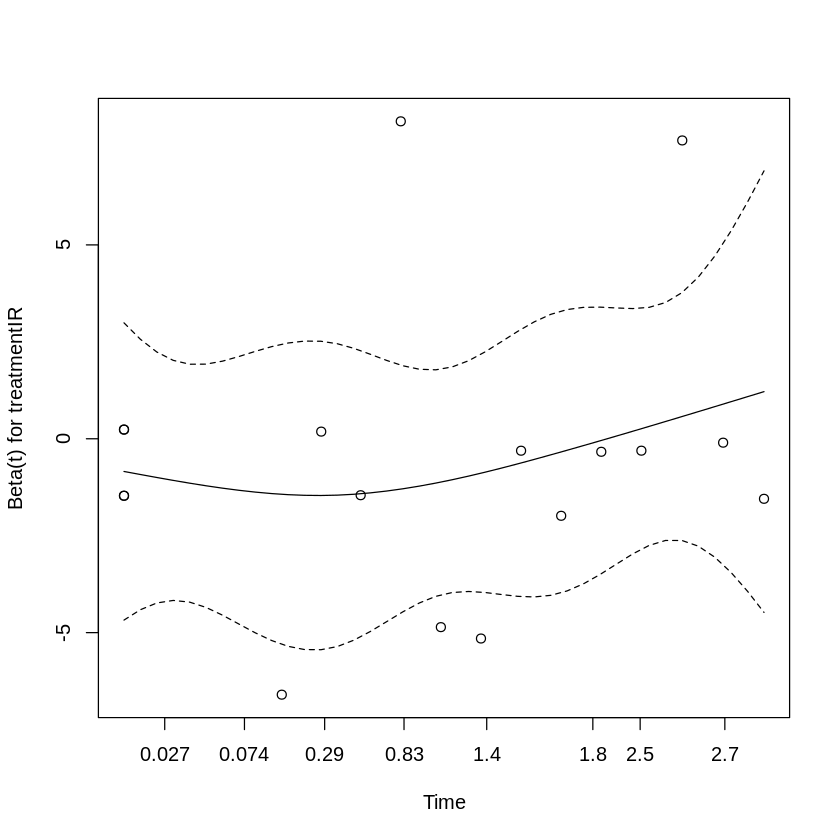

In [307]:
# Check: Linearity assumption
# plot(
#   predict(model_treatment_ssm),
#   residuals(model_treatment_ssm, type = "martingale")
# )
# lines(smooth.spline(predict(multi_cox),
#                     residuals(multi_cox, type = "deviance")))

# Check: Proportional hazards assumption
# H_0: Hazards are proportional
print(cox.zph(model_treatment_ssm))
plot(cox.zph(model_treatment_ssm)[1])

## Week 12 MRD

In [101]:
rpath <- "data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
pid_annot <- read.table(rpath, sep = "\t", header = T, row.names = 1, quote = '"')
pid_annot$label <- as.factor(pid_annot$label)

In [102]:
idx <- intersect(rownames(pid_annot), rownames(m1_p_alltrain))
annot_p <- cbind(
  pid_annot[idx, ],
  p = m1_p_alltrain[idx, ],
  p_wo_mrd = m1a_p_alltrain[idx, ]
)

In [103]:
subtype_distr <- table(pid_annot$subtype, pid_annot$label)
p_relapse <- subtype_distr[, 2] / rowSums(subtype_distr)
subtype_distr
p_relapse

              
                0  1
  BCR-ABL       6  7
  E2A-PBX1      5  2
  Hyperdiploid 35  5
  Hypodiploid   0  1
  MLL           3  5
  Others       66 23
  T-ALL        11  2
  TEL-AML1     33  6

BCR-ABL     E2A-PBX1 Hyperdiploid  Hypodiploid          MLL       Others 
   0.5384615    0.2857143    0.1250000    1.0000000    0.6250000    0.2584270 
       T-ALL     TEL-AML1 
   0.1538462    0.1538462

In [95]:
p_relapse <- p_relapse[as.character(annot_p$subtype)]
ssm_risk <- rep("IR", nrow(annot_p))
ssm_risk[annot_p$p_wo_mrd < p_relapse] <- "HR"

annot_p1 <- cbind(annot_p, ssm_risk)

| | MASPORE 2003 | MASPORE 2010 |
| --- | :--- | :--- |
| SR | Day 33 MRD AND Wk 12 MRD $\le 10^{-4}$ | Day 33 MRD AND Wk 8 MRD $\le 10^{-4}$ |
| HR | Wk 12 MRD $\ge 10^{-3}$  | Day 33 MRD $\ge 10^{-2}$ OR Wk 8 MRD $\ge 10^{-3}$  |

- Subset patients who have SR, IR (<10^-2) Day 33 MRD who later have HR week 12 MRD (>= 10^-3)

In [107]:
print(pid_annot[, c("d33_mrd", "wk12_mrd", "treatment_type", "label")])

      d33_mrd wk12_mrd treatment_type label
P001 5.00e-04    2e-04             IR     0
P004 8.00e-02       NA             HR     0
P005 1.00e-04    1e-08             SR     0
P007 4.00e-03    4e-04             HR     1
P008 1.00e-04    1e-08             IR     0
P009       NA       NA             HR     0
P010 1.00e-04       NA             HR     0
P011       NA    1e-04             IR     0
P012 5.00e-04    1e-08             IR     0
P013 1.00e-04    1e-08             SR     0
P014 1.00e-04    1e-08             SR     0
P015 7.00e-04    1e-08             IR     0
P016 1.00e-04    1e-08             SR     0
P017 1.00e-04    1e-08             SR     0
P018 1.00e-04    1e-08             HR     0
P019 3.00e-03    4e-04             IR     1
P020       NA       NA             IR     0
P022 1.00e-04    1e-06             SR     0
P023 2.00e-04       NA             IR     0
P024 1.00e-04    1e-08             SR     0
P025 1.00e-04    1e-08             SR     0
P026 3.00e-04    5e-04          

#### Day 33 MRD - Wrong, Wk 12 MRD - Correct

In [642]:
# annot_p %>%
#   subset(d33_mrd_risk != "High") %>%
#   subset(label == 1) %>%
#   select(
#     d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
#     treatment_type, label, subtype, p, p_wo_mrd
#   )

In [643]:
# annot_p %>%
#   subset(d33_mrd_risk == "High") %>%
#   select(
#     d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
#     treatment_type, label, subtype, p, p_wo_mrd
#   )

,d33_mrd,d33_mrd_risk,wk12_mrd,maspore,treatment_type,label,subtype,p,p_wo_mrd
,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>
P004,0.08,High,NA,2003,HR,0,T-ALL,0.71875,0.6250000
P051,0.09,High,8e-04,2003,IR,0,E2A-PBX1,0.75000,0.6666667
P057,1.00,High,1e-01,2003,BMT,1,BCR-ABL,0.25000,0.0000000
P102,0.02,High,1e-02,2003,SR,1,E2A-PBX1,0.20000,0.0000000
P103,0.03,High,1e-06,2003,HR,0,T-ALL,0.46875,0.3333333
P116,0.01,High,3e-04,2003,IR,0,T-ALL,0.50000,0.4166667
P122,0.02,High,3e-02,2003,HR,1,MLL,0.25000,0.0000000
P131,0.01,High,7e-04,2003,HR,1,MLL,0.25000,0.0000000
P134,0.09,High,NA,2003,HR,1,BCR-ABL,0.25000,0.0000000


#### SSM (P w/o MRD)
- SR: P > 0.5
- IR: 0.1 < P <= 0.5
- HR: P <= 0.1

In [56]:
# SSM recommends escalating treatment if P(wo mrd) < 0.1
# P102 has Down's syndrome
ssm_change <- annot_p %>%
  subset(p_wo_mrd <= 0.5) %>%
  subset(p_wo_mrd > .1) %>%
  subset(treatment_type %in% c("SR", "IR")) %>%
  select(
    d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
    treatment_type, label, subtype, p, p_wo_mrd
  )
ssm_change

,d33_mrd,d33_mrd_risk,wk12_mrd,maspore,treatment_type,label,subtype,p,p_wo_mrd
,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>
P012,5e-04,Intermediate,1e-08,2003,IR,0,T-ALL,0.4375000,0.3750000
P013,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.5689655,0.4827586
P014,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.5172414,0.4137931
P015,7e-04,Intermediate,1e-08,2003,IR,0,TEL-AML1,0.4655172,0.2873563
P016,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.3448276,0.1839080
P022,1e-04,Standard,1e-06,2003,SR,0,TEL-AML1,0.3362069,0.1724138
P024,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.5000000,0.3908046
P026,3e-04,Intermediate,5e-04,2003,IR,0,TEL-AML1,0.3620690,0.1724138
P028,2e-04,Intermediate,NA,2003,IR,0,TEL-AML1,0.3620690,0.1839080


#### SSM
- SR: P > 0.5
- HR: P <= 0.25

In [75]:
# SSM recommends escalating treatment if P(wo mrd) < 0.1
# P102 has Down's syndrome
ssm_change <- annot_p %>%
  subset(p <= 0.5) %>%
  subset(p > .25) %>%
  subset(treatment_type %in% c("SR", "IR")) %>%
  select(
    d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
    treatment_type, label, subtype, p, p_wo_mrd
  )
ssm_change

,d33_mrd,d33_mrd_risk,wk12_mrd,maspore,treatment_type,label,subtype,p,p_wo_mrd
,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>
P012,5e-04,Intermediate,1e-08,2003,IR,0,T-ALL,0.4375000,0.37500000
P015,7e-04,Intermediate,1e-08,2003,IR,0,TEL-AML1,0.4655172,0.28735632
P016,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.3448276,0.18390805
P019,3e-03,Intermediate,4e-04,2003,IR,1,TEL-AML1,0.2672414,0.02298851
P022,1e-04,Standard,1e-06,2003,SR,0,TEL-AML1,0.3362069,0.17241379
P023,2e-04,Intermediate,NA,2003,IR,0,TEL-AML1,0.2931034,0.09195402
P024,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.5000000,0.39080460
P026,3e-04,Intermediate,5e-04,2003,IR,0,TEL-AML1,0.3620690,0.17241379
P028,2e-04,Intermediate,NA,2003,IR,0,TEL-AML1,0.3620690,0.18390805


In [100]:
# SSM recommends escalating treatment if P(wo mrd) < 0.1
# P102 has Down's syndrome
ssm_change <- annot_p1 %>%
  subset(ssm_risk == "IR") %>%
  subset(treatment_type %in% c("SR", "IR")) %>%
  select(
    d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
    treatment_type, label, subtype, p, p_wo_mrd, ssm_risk
  )
ssm_change

,d33_mrd,d33_mrd_risk,wk12_mrd,maspore,treatment_type,label,subtype,p,p_wo_mrd,ssm_risk
,<dbl>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
P001,5e-04,Intermediate,2e-04,2003,IR,0,T-ALL,0.8125000,0.8750000,IR
P005,1e-04,Standard,1e-08,2003,SR,0,T-ALL,0.7187500,0.8333333,IR
P008,1e-04,Standard,1e-08,2003,IR,0,T-ALL,0.7812500,0.9166667,IR
P012,5e-04,Intermediate,1e-08,2003,IR,0,T-ALL,0.4375000,0.3750000,IR
P013,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.5689655,0.4827586,IR
P014,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.5172414,0.4137931,IR
P015,7e-04,Intermediate,1e-08,2003,IR,0,TEL-AML1,0.4655172,0.2873563,IR
P016,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.3448276,0.1839080,IR
P017,1e-04,Standard,1e-08,2003,SR,0,TEL-AML1,0.7068966,0.6666667,IR


#### Plot: Risk number ratios / Threshold

In [ ]:
# ggplot(
#   ssm_change,
#   aes(x = treatment_type, y = p, fill = label)
# ) +
#   geom_point(
#     position = position_jitterdodge(),
#     pch = 21, cex = 2
#   ) +
#   scale_fill_manual(values = COL_LABEL)

In [50]:
# # SSM recommends escalate treatment
# ssm_change <- annot_p %>%
#   subset(p <= .5) %>%
#   subset(treatment_type %in% c("SR", "IR")) %>%
# #   subset(d33_mrd_risk != "High") %>% # Removes patient with Down syndrome (high mrd, SR)
#   select(
#     d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
#     treatment_type, label, subtype, p, p_wo_mrd
#   )
# ssm_change

In [49]:
# # SSM recommends escalate treatment
# ssm_change1 <- annot_p %>%
#   subset(p > .5) %>%
#   subset(treatment_type %in% c("SR","IR", "HR", "BMT")) %>%
# #   subset(d33_mrd_risk != "High") %>% # Removes patient with Down syndrome (high mrd, SR)
#   select(
#     d33_mrd, d33_mrd_risk, wk12_mrd, maspore,
#     treatment_type, label, subtype, p, p_wo_mrd
#   )
# ssm_change1